In [2]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jun  4 03:06:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os 
os.chdir('drive/MyDrive/OASIS_Data')

In [5]:
import copy 
import time
import datetime
import numpy as np 
import pandas as pd 
import nibabel as nib
import sklearn as skl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import torch 
from torch.utils.data import Dataset, DataLoader
from torch import nn 
from torch import optim

In [6]:
pip install torchio nilearn

     |████████████████████████████████| 153kB 14.7MB/s 
     |████████████████████████████████| 3.1MB 26.2MB/s 
     |████████████████████████████████| 42.5MB 122kB/s 


In [7]:
import torchio as tio 

In [8]:
os.chdir("MRI_SOMVAE")
from OASISDataset import *
from FullModels import *
from TrainingTesting import *
from ExtraMetrics import *
from RegularSOM import *
from plotting_tools import *
os.chdir("..")

Split dataset into train and val 

In [9]:
fulltrainlist = pd.read_csv("oasis_ctrl_training.csv")

trainlist,vallist = train_test_split(fulltrainlist, random_state=128, test_size=0.15)

folder = "ctrl_original_resolution"

In [10]:
start = time.time()
traindataset = OASISDataset_Colab(folder,trainlist)
print(time.time()-start)
valdataset = OASISDataset_Colab(folder,vallist)
print(time.time()-start)

214.62144875526428
251.80920243263245


In [11]:
batch_size=32

train_dataloader = DataLoader(traindataset,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(valdataset,batch_size=len(valdataset),shuffle=True)

In [15]:
img_idx = 100
mid_idx = 90 

In [16]:
def get_unique_embeddings_SOM(model,dataset,idx,skip=False,verbose=True):
    """
    Same as get_unique_embeddings() but used with the SOMVAE model 
    """
    before = dataset[idx][0].unsqueeze(1)
    if skip==False: 
        encoded = model.encoder(before)
    else:
        _,_,_,encoded = model.encoder(before)
    _,_,embed = model.quantization(encoded)
    embed = embed.detach().cpu().numpy()
    full_shape = embed.shape[1]
    embed_used = np.unique(embed,axis=0)
    if verbose == True:
        print(f"Number of embeddings actually used is {embed_used.shape[0]} out of {full_shape}")
    return(embed_used)


##Baseline VQVAE

In [29]:
BaseVQVAE = VQVAE3D(num_channels=1,num_filters=4,embedding_dim=32,num_embeddings=256,skip_connections=False,batchnorm=True)
BaseVQVAE.load_state_dict(torch.load("VQVAE32_4filters_256Embed_NoSkip_120epochs_Trial1.pth"))
BaseVQVAE.eval()

VQVAE3D(
  (encoder): VQEncoder(
    (conv1): Sequential(
      (0): Conv3d(1, 4, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(4, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(8, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv4): Sequential(
      (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    )
  )
  (quantization): VectorQuantizerEMA(
    (_embedding): Embedding(256, 32)
  )
  (decoder): VQDecoder(
    (conv1): Sequential(
      (0): ConvTranspose3d(32, 16, kernel_size=

In [40]:
BaseVQVAE_tsne = get_TSNE_encodings(BaseVQVAE,traindataset,100)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


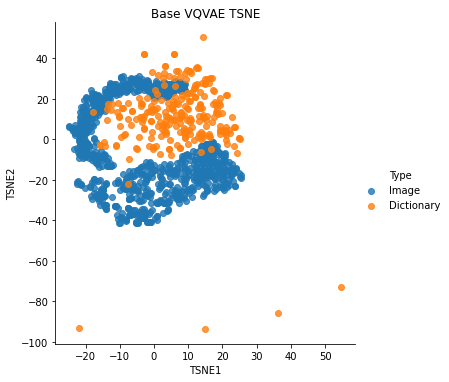

In [41]:
sns.lmplot("TSNE1","TSNE2",data=BaseVQVAE_tsne,hue="Type",fit_reg = False)
plt.title("Base VQVAE TSNE")
plt.show()

## VQVAE with K Means and AE weights 

In [45]:
VQVAE_KM = VQVAE3D(num_channels=1,num_filters=4,embedding_dim=32,num_embeddings=256,skip_connections=False,batchnorm=True)
VQVAE_KM.load_state_dict(torch.load("VQVAEVanillaCombo_4filters_120_epochs_KMeansinit_NoSkip_Trial1.csv.pth"))
VQVAE_KM.eval()

VQVAE3D(
  (encoder): VQEncoder(
    (conv1): Sequential(
      (0): Conv3d(1, 4, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(4, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(8, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv4): Sequential(
      (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    )
  )
  (quantization): VectorQuantizerEMA(
    (_embedding): Embedding(256, 32)
  )
  (decoder): VQDecoder(
    (conv1): Sequential(
      (0): ConvTranspose3d(32, 16, kernel_size=

In [46]:
VQVAE_KM_tsne = get_TSNE_encodings(VQVAE_KM,traindataset,100)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


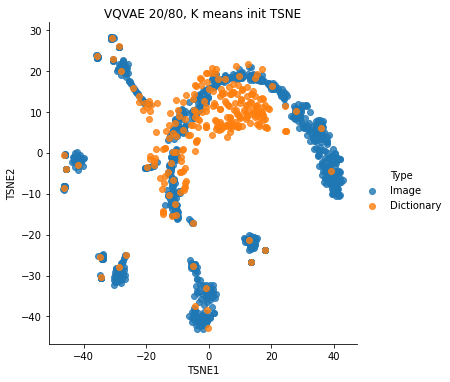

In [48]:
sns.lmplot("TSNE1","TSNE2",data=VQVAE_KM_tsne,hue="Type",fit_reg = False)
plt.title("VQVAE 20/80, K means init TSNE")
plt.show()

## SOMVAE rectangular

In [14]:
SOMVAErect_checkpt = torch.load("SOMVAE32_256_4filters_700epochs_rectangular_052921.tar")
SOMVAErect = SOMVAE3D(num_channels = 1,num_filters = 4,embedding_dim = 32, num_embeddings = 256, som_h = 16,som_w = 16,alpha = 6, beta =1,geometry="rectangular",batchnorm=True)
SOMVAErect.load_state_dict(SOMVAErect_checkpt["model_state_dict"])

<All keys matched successfully>

In [15]:
SOMVAErect.eval()

SOMVAE3D(
  (encoder): VQEncoder(
    (conv1): Sequential(
      (0): Conv3d(1, 4, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(4, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(8, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv4): Sequential(
      (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    )
  )
  (quantization): SOMQuantizer(
    (_embedding): Embedding(256, 32)
  )
  (decoder): VQDecoder(
    (conv1): Sequential(
      (0): ConvTranspose3d(32, 16, kernel_size=(4, 4

In [22]:
get_unique_embeddings_SOM(SOMVAErect,traindataset,img_idx)

Number of embeddings actually used is 113 out of 256


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [23]:
SOMVAErec_tsne = get_TSNE_encodings(SOMVAErect,traindataset,img_idx)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


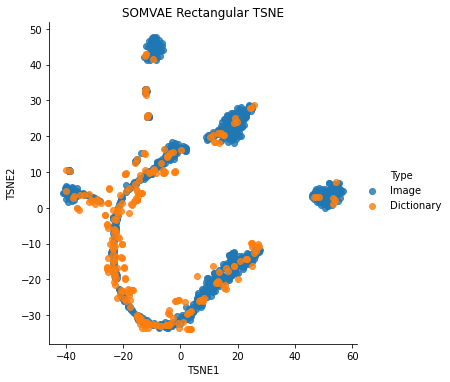

In [24]:
sns.lmplot("TSNE1","TSNE2",data=SOMVAErec_tsne,hue="Type",fit_reg = False)
plt.title("SOMVAE Rectangular TSNE")
plt.show()

In [25]:
som_codebook = SOMVAErect.quantization._embedding.weight.detach().cpu().numpy()
som_codebook_grid = som_codebook.reshape(16,16,-1)

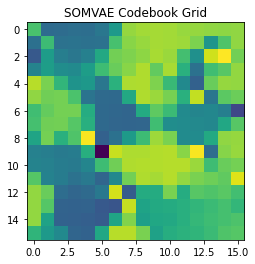

In [26]:
plt.imshow(som_codebook.sum(axis=1).reshape(16,16))
plt.title("SOMVAE Codebook Grid")
plt.show()

The above codebook grid has a similiar structure in nodes closer together

## PSOMVAE Toroid

In [16]:
PSOMVAE_checkpt = torch.load("PSOMVAE32_256_4filters_800epochs_toroid_gamma10beta1_060121.tar")
PSOMVAE = PSOMVAE3D(num_channels=1,num_filters=4,embedding_dim=32,num_embeddings=256,som_h=16,som_w=16,gamma=1,beta=1,geometry="toroid",batchnorm=True)
PSOMVAE.load_state_dict(PSOMVAE_checkpt["model_state_dict"])

<All keys matched successfully>

In [17]:
PSOMVAE.eval()

PSOMVAE3D(
  (encoder): VQEncoder(
    (conv1): Sequential(
      (0): Conv3d(1, 4, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(4, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(8, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv4): Sequential(
      (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    )
  )
  (quantization): PSOMQuantizer(
    (_embedding): Embedding(256, 32)
  )
  (decoder): VQDecoder(
    (conv1): Sequential(
      (0): ConvTranspose3d(32, 16, kernel_size=(4,

In [41]:
PSOMVAE_checkpt.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'train_loss', 'val_loss', 'trainSSIM', 'valSSIM', 'trainPSNR', 'valPSNR'])

In [42]:
PSOMVAE_checkpt["train_loss"][-1]

1.05283322930336

In [43]:
PSOMVAE_checkpt["val_loss"][-1]

1.3401849166206692

In [44]:
PSOMVAE_checkpt["trainSSIM"]

tensor(0.9050, device='cuda:0')

In [45]:
PSOMVAE_checkpt["valSSIM"]

tensor(0.9050, device='cuda:0')

In [46]:
PSOMVAE_checkpt["trainPSNR"]

tensor(25.9287, device='cuda:0')

In [47]:
PSOMVAE_checkpt["valPSNR"]

tensor(26.5178, device='cuda:0')

In [29]:
PSOMVAE_tsne = get_TSNE_encodings(PSOMVAE,traindataset,img_idx)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


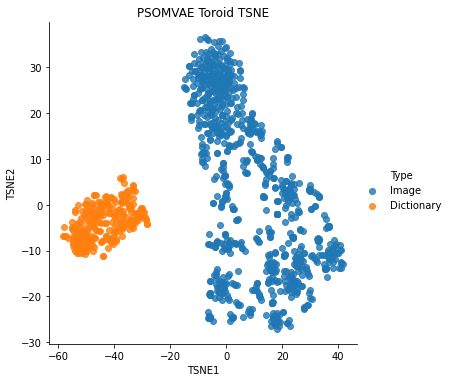

In [30]:
sns.lmplot("TSNE1","TSNE2",data=PSOMVAE_tsne,hue="Type",fit_reg = False)
plt.title("PSOMVAE Toroid TSNE")
plt.show()

TSNE suggests the codebook dictionary and encoder image output is very distinct, which implies the codebook is not capturing all the information needed although the image reconstruction SSIM is high at 0.91

In [31]:
psom_codebook = PSOMVAE.quantization._embedding.weight.detach().cpu().numpy()
psom_codebook_grid = psom_codebook.reshape(16,16,-1)

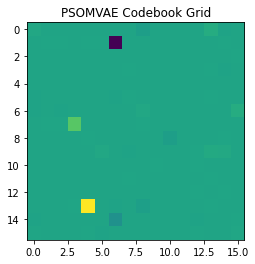

In [32]:
plt.imshow(psom_codebook.sum(axis=1).reshape(16,16))
plt.title("PSOMVAE Codebook Grid")
plt.show()

The codebook with the PSOM VAE is overly smooth, and all nodes have approximately the same 32 dimensional vector.

# Investigating Voxel to SOM Grid Mapping (SOMVAE) 

We use the SOMVAE despite the lower reconstruction SSIM of 0.82 since the codebook is more differentiated, and thus would have a greater ability to embed local brain regions

In [10]:
import colorsys 

In [82]:
from skimage import data, color, io, img_as_float


Below is the SOM grid assigned colors which will be projected onto the original image

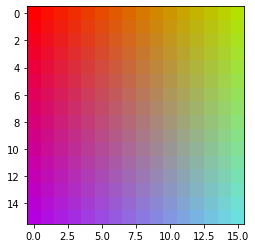

In [31]:
rgb_new = np.zeros((16,16,3),dtype=int)
for i in range(16):
  for j in range(16):
    rgb_new[:,i,1] = 15*i
    rgb_new[j,:,2] = 15*j
    rgb_new[i,j,0] = 255 - 5*(i+j)
plt.imshow(rgb_new)
plt.show()


The above color grid represents the assigned color to the SOM grid. The goal is to investigate the mapping from this grid to the original image. Ideally, we want brain regions closer together to obtain the same color, which is evidence that more similar regions in the original image are being assigned to similar regions in the 2D grid, and thus the 2D grid captures important information in the original image

In [62]:
img = traindataset[img_idx][0].unsqueeze(0)

img_np = img.squeeze(0).squeeze(0).detach().cpu().numpy()

img_enc = SOMVAErect.encoder(img)

img_enc_perm = img_enc.permute(0, 2, 3, 4, 1)

img_enc_flatten = img_enc_perm.reshape(-1,32)

img_enc_unflatten = img_enc_flatten.reshape(1,9,11,9,32)

_,_,encodings = SOMVAErect.quantization(img_enc)

encodings_idx = torch.argmax(encodings,dim=1,keepdims=True)

encodings_idx_cube = encodings_idx.reshape(1,9,11,9,1)


Construct encodings tensor that contains the rgb vector corresponding to the best matching node for the voxel at that location. Upsample the resulting volume by 16x to get back dimensions of the original input image. 

In [63]:

encodings_rgb = torch.zeros(891,3)

rgb_new=torch.from_numpy(rgb_new)
for i in range(891):
    h,w = SOMVAErect.quantization.idx_to_coord[encodings_idx[i,:].item()]
    encodings_rgb[i,:] = rgb_new[h,w]

encodings_rgb_cube = encodings_rgb.reshape(1,9,11,9,3).permute(0,4,1,2,3)


In [64]:
upsamp = nn.Upsample(scale_factor=16)

In [65]:
encodings_rgb_cube_up = upsamp(encodings_rgb_cube)
encodings_rgb_cube_up_np = encodings_rgb_cube_up.squeeze(0).squeeze(0).detach().numpy()

In [139]:
idx = 30
img_slice = img_np[idx,:,:]
col_slice = encodings_rgb_cube_up_np[:,idx,:,:].transpose(1,2,0)

img_slice = np.rot90(img_slice)
col_slice = np.rot90(col_slice)


In [140]:
img_slice_stack = np.dstack((img_slice, img_slice, img_slice))

In [141]:
img_hsv = color.rgb2hsv(img_slice_stack)
color_mask_hsv = color.rgb2hsv(col_slice)

In [142]:
alpha = 0.6 

img_hsv[..., 0] = color_mask_hsv[..., 0]
img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha


In [143]:
img_masked = color.hsv2rgb(img_hsv)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


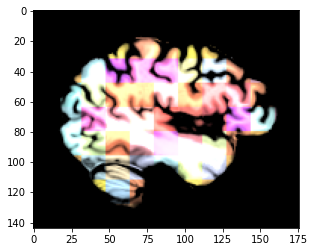

In [144]:
plt.imshow(img_masked)
plt.show()

We have successfully mapped brain regions closer together to locations in the SOM grid that are closer together, as evidenced by the similar color in adjacent regions above

# Assessing Test Set 

In [12]:
testlist = pd.read_csv("oasis_ctrl_testing.csv")

In [13]:
start = time.time()
testdataset = OASISDataset_Colab(folder,testlist)
print(time.time()-start)

50.09920811653137


In [18]:
test_dataloader = DataLoader(testdataset,batch_size=batch_size,shuffle=True)

In [19]:
temp_testSSIM = []
temp_testPSNR = []


with torch.no_grad():
      use_cuda = torch.cuda.is_available()
      device = torch.device("cuda:0" if use_cuda else "cpu")
      torch.backends.cudnn.benchmark = True
      if use_cuda:
        if torch.cuda.device_count() > 1:
          print("Let's use", torch.cuda.device_count(), "GPUs!")
          # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
          SOMVAErect = nn.DataParallel(SOMVAErect) #NewVQVAE = nn.DataParallel(NewVQVAE)
      SOMVAErect.to(device)#NewVQVAE.to(device)
      SOMVAErect.eval()#NewVQVAE.eval()
      for Xin_test,Xout_test in test_dataloader:
          Xin_test,Xout_test = Xin_test.to(device), Xout_test.to(device)
          Xrecon_test = SOMVAErect(Xin_test)["x_out_ze"]#NewVQVAE(Xin_train)["x_out_ze"]
          test_psnr_batch = PSNR(Xout_test,Xrecon_test)
          temp_testPSNR.append(test_psnr_batch)
          #if epoch % 2 == 0:
          test_ssim_batch = SSIM(Xout_test,Xrecon_test)
          temp_testSSIM.append(test_ssim_batch)

In [20]:
SSIMtest = torch.cat(temp_testSSIM).mean()
print(SSIMtest)

PSNRtest = torch.cat(temp_testPSNR).mean()
print(PSNRtest)

tensor(0.8163, device='cuda:0')
tensor(22.8042, device='cuda:0')


Assessing PSOMVAE

In [22]:
temp_testSSIM = []
temp_testPSNR = []


with torch.no_grad():
      use_cuda = torch.cuda.is_available()
      device = torch.device("cuda:0" if use_cuda else "cpu")
      torch.backends.cudnn.benchmark = True
      if use_cuda:
        if torch.cuda.device_count() > 1:
          print("Let's use", torch.cuda.device_count(), "GPUs!")
          # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
          PSOMVAE = nn.DataParallel(PSOMVAE) #NewVQVAE = nn.DataParallel(NewVQVAE)
      PSOMVAE.to(device)#NewVQVAE.to(device)
      PSOMVAE.eval()#NewVQVAE.eval()
      for Xin_test,Xout_test in test_dataloader:
          Xin_test,Xout_test = Xin_test.to(device), Xout_test.to(device)
          Xrecon_test = PSOMVAE(Xin_test)["x_out"]#NewVQVAE(Xin_train)["x_out_ze"]
          test_psnr_batch = PSNR(Xout_test,Xrecon_test)
          temp_testPSNR.append(test_psnr_batch)
          #if epoch % 2 == 0:
          test_ssim_batch = SSIM(Xout_test,Xrecon_test)
          temp_testSSIM.append(test_ssim_batch)

In [23]:
SSIMtest = torch.cat(temp_testSSIM).mean()
print(SSIMtest)

PSNRtest = torch.cat(temp_testPSNR).mean()
print(PSNRtest)

tensor(0.9012, device='cuda:0')
tensor(25.1597, device='cuda:0')
